# Colorizing a Greyscale Image based on a Color Source
Based on "A Proposed Method for Colorizing Grayscale Images", Khalil & Ali 2013.

https://www.academia.edu/3486962/A_Proposed_Method_for_Colorizing_Grayscale_Images

Their method:
1. Start with a color source image and grayscale target image.
2. Create a grayscale version of your source image using Gray = 0.299 Red + 0.587 Green + 0.114 Blue.
3. For each pixel in the grayscale source image, compute three inputs: lumniosity, mean luminosity of neighbors, and sd of luminosity of neighbors.
4. Train on the RGB values of the color source image.
5. Apply to grayscale target image.

Instead of hardcoding the luminosity, mean neighbor luminosity, and sd of neighbor luminosity, we can use a small number of convolutional kernels.

In [1]:
import image
import os
import random
import numpy as np
import scipy as sp
import time

import lasagne
import theano
import theano.tensor as T

from scipy import misc

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 4)

In [2]:
imdir = "images/raw"
handles = os.listdir(imdir)
random.shuffle(handles)
print "Found {l} image handles".format(l=len(handles))

Found 20082 image handles


Original shape is (304, 500, 3)


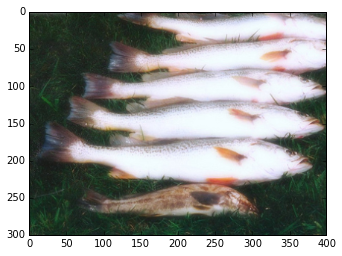

In [84]:
reload(image)
im = None
for handle in handles:
    try:
        im = misc.imread(os.path.join(imdir, handle))
        if im is not None:
            break
    except Exception as e:
        print e
print "Original shape is", im.shape
im = image.DownsampledPatch(im, 400, 300)
plt.imshow(im)
plt.show()

In [285]:
def BuildNet(input_var):
    # Input is a vector of length 3.
    l_in = lasagne.layers.InputLayer(
        shape=(1, 3),
        input_var=input_var)
    l_dense = lasagne.layers.DenseLayer(
        l_in,
        num_units=20,
        nonlinearity=lasagne.nonlinearities.tanh,
        W=lasagne.init.GlorotUniform())
    l_out = lasagne.layers.DenseLayer(
        l_dense,
        num_units=3,
        nonlinearity=lasagne.nonlinearities.identity,
        W=lasagne.init.GlorotUniform())
    l_flat = lasagne.layers.FlattenLayer(
        l_out,
        outdim=1)
    return l_flat

In [286]:
def PrintShapes(net):
    print net.__class__.__name__, getattr(net, "input_shape", ""), "=>", getattr(net, "output_shape", "")
    input_layer = getattr(net, "input_layer", None)
    if input_layer:
        Shapes(input_layer)


def CreateTheanoExprs():
    pixel_var = T.matrix("pixel")
    rgb_var = T.vector("rgb")
    net = BuildNet(pixel_var)
    prediction = lasagne.layers.get_output(net)
    loss = lasagne.objectives.squared_error(prediction, rgb_var).mean()
    params = lasagne.layers.get_all_params(net, trainable=True)
    updates = lasagne.updates.sgd(loss, params, learning_rate=0.05)
    train_fn = theano.function(
        [pixel_var, rgb_var],
        loss,
        updates=updates,
        name="Train")
    val_fn = theano.function(
        [pixel_var],
        prediction,
        name="Evaluate")
    PrintShapes(net)
    return net, train_fn, val_fn


def Gray(im):
    return (im[:, :, 0] * 0.299 +
            im[:, :, 1] * 0.587 +
            im[:, :, 2] * 0.114)

def Features(gray):
    perms = np.array((
        (-1, 1), (0, 1), (1, 1),
        (-1, 0), (0, 0), (1, 0),
        (-1, -1), (0, -1), (1, -1)))
    h, w = gray.shape
    pixels = np.stack(
        [gray[yoff + 1:h + yoff - 1, xoff + 1:w + xoff -1]
         for xoff, yoff in perms],
        axis=2).reshape(((gray.shape[0] - 2) * (gray.shape[1] - 2), 9))
    pixels = np.stack(
        (pixels[:, 4],  # The luminosity of the pixel itself,
         pixels.mean(axis=1),
         pixels.std(axis=1)),
        axis=1)
    return pixels


def Train(reps, im, net, train_fn):
    # Preprocess
    gray = Gray(im)
    pixels = Features(gray)
    rgb = im[1:-1, 1:-1, :].reshape(
        ((im.shape[0] - 2) * (im.shape[1] - 2), 3))

    # Train
    train_errs = []
    mark = time.time()
    for r in xrange(reps):
        rep_errs = []
        for p in xrange(pixels.shape[0]):
            err = (train_fn(pixels[p].reshape((1, 3)), rgb[p]))
            rep_errs.append(err)
        new_mark = time.time()
        print "Finished repetition {r} in {t} seconds. Error = {e:.4f}".format(
                r=r, t=(new_mark - mark), e=np.mean(rep_errs))
        mark = new_mark
        train_errs.append(rep_errs)
    return net, train_errs


def Reconstruct(gray, val_fn):
    pixels = Features(gray)
    restored = np.array(
        [val_fn(pixels[p].reshape((1, 3)))
         for p in xrange(pixels.shape[0])])
    return restored

In [287]:
net, train_fn, val_fn = CreateTheanoExprs()

FlattenLayer (1, 3) => (3,)
DenseLayer (1, 20) => (1, 3)
DenseLayer (1, 3) => (1, 20)
InputLayer  => (1, 3)


In [288]:
net, train_errs = Train(20, im, net, train_fn)

Finished repetition 0 in 5.36691498756 seconds. Error = 80.8990
Finished repetition 1 in 5.17172408104 seconds. Error = 80.8045
Finished repetition 2 in 5.06861495972 seconds. Error = 80.8045
Finished repetition 3 in 5.01402688026 seconds. Error = 80.8045
Finished repetition 4 in 5.03408718109 seconds. Error = 80.8045
Finished repetition 5 in 5.04420590401 seconds. Error = 80.8013
Finished repetition 6 in 5.01900601387 seconds. Error = 80.8045
Finished repetition 7 in 5.04895496368 seconds. Error = 80.8045
Finished repetition 8 in 5.10403609276 seconds. Error = 80.8045
Finished repetition 9 in 5.03580594063 seconds. Error = 80.8059
Finished repetition 10 in 5.08449912071 seconds. Error = 80.8045
Finished repetition 11 in 5.11888194084 seconds. Error = 80.8045
Finished repetition 12 in 5.21164083481 seconds. Error = 80.8045
Finished repetition 13 in 5.69175601006 seconds. Error = 80.8045
Finished repetition 14 in 5.59471106529 seconds. Error = 80.8045
Finished repetition 15 in 5.0396270

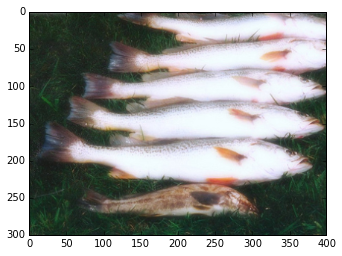

In [289]:
plt.imshow(im)
plt.show()

In [290]:
rec = Reconstruct(Gray(im), val_fn)

In [2]:
plt.imshow(rec.reshape((im.shape[0] - 2, im.shape[1] - 2, 3)))

NameError: name 'rec' is not defined

In [ ]:
T.st